# Import Library

In [1]:
from run import *
from tqdm import tqdm
import pandas as pd
from utils.explainer import *
from exp.exp_interpret import *

from tint.attr import (
    FeatureAblation
)

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from exp.plot_config import *
%matplotlib inline

In [2]:
def normalize(item:np.ndarray, axis=(2,3), l1_norm=False):
    minimum = item.min(axis=axis, keepdims=True)
    maximum = item.max(axis=axis, keepdims=True)
    attr_minmax = (item - minimum)/(maximum-minimum)

    if l1_norm:
        attr_sum = attr_minmax.sum(axis=axis, keepdims=True)
        return attr_minmax / attr_sum 
    else:
        return attr_minmax

# Argument Parser

In [3]:
parser = get_parser()
argv = """
  --task_name classification \
  --data mimic \
  --root_path ./dataset/mimic_iii/ \
  --data_path mimic_iii.pkl \
  --model Crossformer 
""".split()
args = parser.parse_args(argv)

# Disable cudnn if using cuda accelerator.
# Please see https://captum.ai/docs/faq#how-can-i-resolve-cudnn-rnn-backward-error-for-rnn-or-lstm-network
# args.use_gpu = False
initial_setup(args)
setting = stringify_setting(args)

In [4]:
output_folder = os.path.join(args.result_path, setting)
figures = os.path.join(output_folder, 'figures')

# Initialize Experiment

In [5]:
if args.task_name == 'classification': Exp = Exp_Classification
else: Exp = Exp_Long_Term_Forecast
exp = Exp(args)  # set experiments
_, dataloader = exp._get_data(args.flag)

exp.load_best_model()

Use GPU: cuda:0
train 18390
test 2299
Experiments will be saved in ./results\mimic_iii_Crossformer
test 2299
Loading model from ./results\mimic_iii_Crossformer\checkpoint.pth


# Evaluation

## Model

In [6]:
model = exp.model
model.eval()

# only need to output targets, sinec interpretation is based on outputs
assert not exp.args.output_attention

# Interpret

In [7]:
name = 'feature_ablation'
explainer = FeatureAblation(model)
baseline_mode = 'random'

In [8]:
sliding_window_shapes = (1, 1)
strides = 1

In [9]:
vital_IDs = ['HeartRate' , 'SysBP' , 'DiasBP' , 'MeanBP' , 'RespRate' , 'SpO2' , 'Glucose' ,'Temp']
others = ['gender', 'age', 'ethnicity', 'first_icu_stay']
lab_IDs = [
    'ANION GAP', 'ALBUMIN', 'BICARBONATE', 'BILIRUBIN', 
    'CREATININE', 'CHLORIDE', 'GLUCOSE', 'HEMATOCRIT', 
    # 'HEMOGLOBIN' 'LACTATE' -> 'HEMOGLOBIN', 'LACTATE'. But the source preprocessing uses it like this
    'HEMOGLOBIN' 'LACTATE', 'MAGNESIUM', 'PHOSPHATE', 
    'PLATELET', 'POTASSIUM', 'PTT', 'INR', 
    'PT', 'SODIUM', 'BUN', 'WBC'
]
mimic_iii_features = vital_IDs + others + lab_IDs

## Evaluate

In [11]:
results = [['batch_index', 'metric', 'area', 'comp', 'suff']]
attrs_tsr = []
attrs = []

progress_bar = tqdm(
    enumerate(dataloader), total=len(dataloader)
)

labels = []
for batch_index, (batch_x, batch_y, padding_mask) in progress_bar:
    batch_x = batch_x.float().to(exp.device)
    labels.append(batch_y)
    padding_mask = padding_mask.float().to(exp.device)
        
    inputs = batch_x
    # baseline must be a scaler or tuple of tensors with same dimension as input
    baselines = get_baseline(inputs, mode=baseline_mode)
    additional_forward_args = (padding_mask, None, None)
    
    # get attributions
    batch_attr = compute_attr(
        inputs, baselines, explainer, 
        additional_forward_args, args
    )

    # get attributions
    batch_attr_tsr = compute_tsr_attr(
        args, explainer, inputs=inputs, 
        sliding_window_shapes=sliding_window_shapes, 
        strides=strides, baselines=baselines,
        additional_forward_args=additional_forward_args
    )
    
    attrs.append(batch_attr)
    attrs_tsr.append(batch_attr_tsr)
    # if batch_index == 2:
    break
    
attrs_tsr = torch.vstack(attrs_tsr)
attrs = torch.vstack(attrs)
labels = torch.vstack(labels)

  0%|          | 0/72 [00:15<?, ?it/s]


In [12]:
dead_patient = alive_patient = -1
for i in range(labels.shape[0]):
    if labels[i] == 1 and dead_patient == -1:
        dead_patient = i
    elif alive_patient == -1:
        alive_patient = i
        
    if dead_patient > -1 and alive_patient > -1:
        break
    
print(dead_patient, alive_patient)

9 0


## Individual attribution

### Mortality within a week

In [13]:
attr = attrs[dead_patient].detach().cpu().numpy()

# taking absolute since we only care for magnitude
attr_abs = np.abs(attr)
most_impactful_feature = attr_abs.sum(axis=0).argmax()

# how many of the top features
top_k = 2
# index of those top features
top_features = np.argpartition(attr_abs.sum(axis=0), -top_k, axis=-1)[-top_k:]

# attr_normed = normalize(attr, axis=(1))

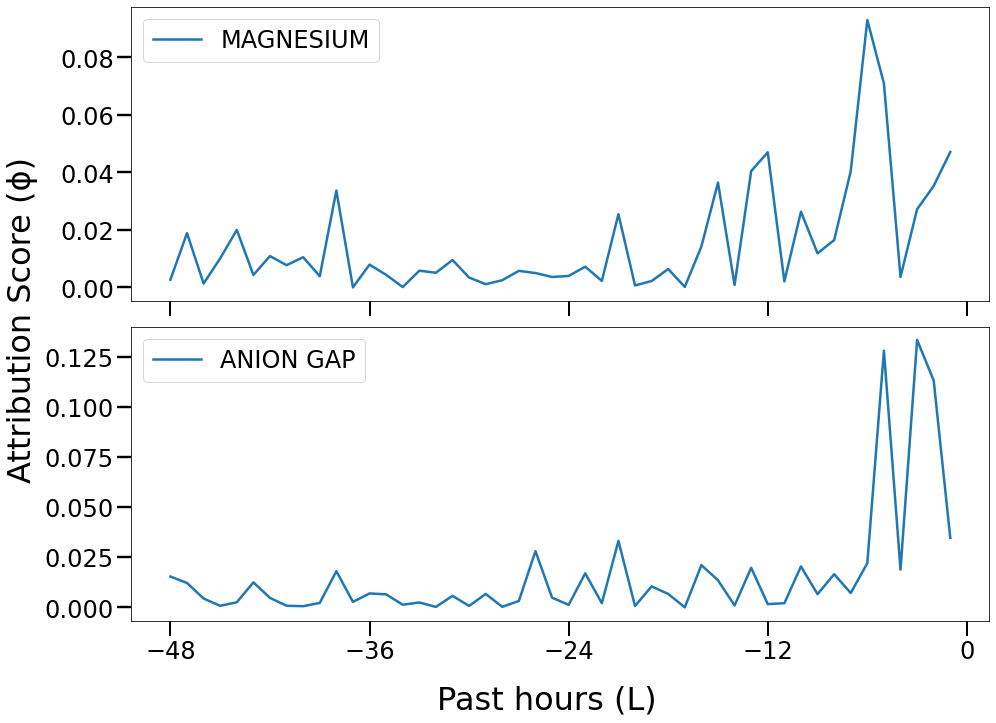

In [14]:
fig, axes = plt.subplots(top_k, figsize=(14, 10), sharex=True)
for i in range(top_k):
    X = range(-attr.shape[0], 0)
    Y = attr[:, top_features[i]]
    axes[i].plot(X, Y, label=mimic_iii_features[top_features[i]])
    axes[i].legend(loc='upper left')
    axes[i].xaxis.set_major_locator(MultipleLocator(base=12))


fig.supylabel('Attribution Score (ϕ)', fontsize=32, x=0.015, y=0.55)
fig.supxlabel('Past hours (L)', fontsize=32, y=0, x=0.55)

fig.tight_layout()
# plt.savefig(os.path.join(output_folder, '1.jpg'), dpi=200)
plt.show()

### No mortality within a week

In [35]:
attr = attrs[alive_patient].detach().cpu().numpy()

# taking absolute since we only care for magnitude
attr_abs = np.abs(attr)
most_impactful_feature = attr_abs.sum(axis=0).argmax()

# how many of the top features
top_k = 2
# index of those top features
top_features = np.argpartition(attr_abs.sum(axis=0), -top_k, axis=-1)[-top_k:]

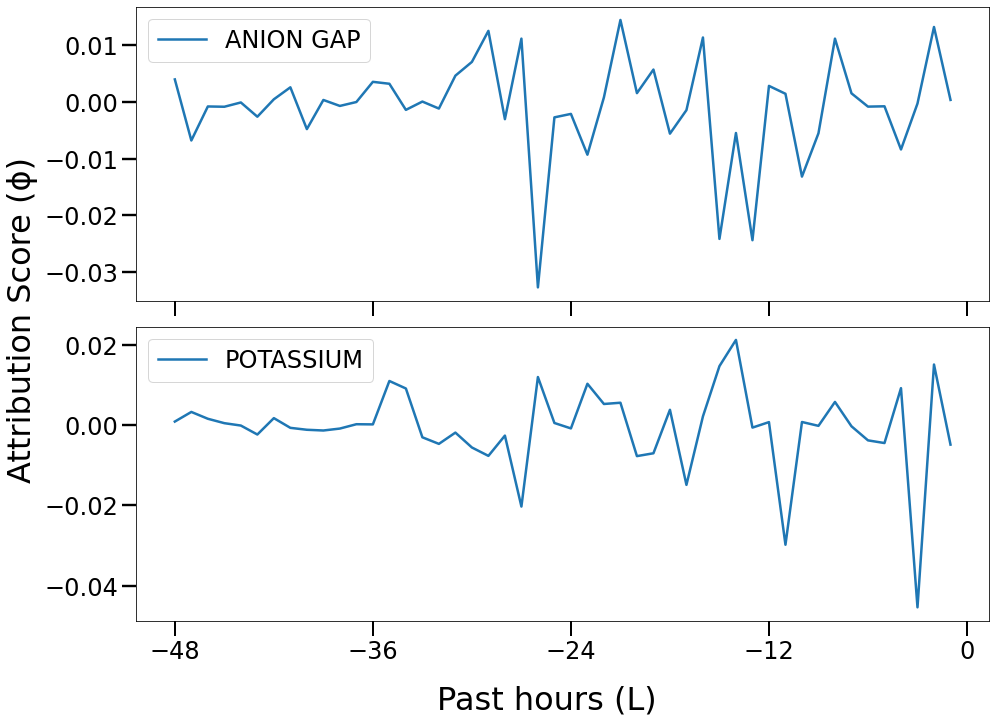

In [36]:
fig, axes = plt.subplots(top_k, figsize=(14, 10), sharex=True)
for i in range(top_k):
    X = range(-attr.shape[0], 0)
    Y = attr[:, top_features[i]]
    axes[i].plot(X, Y, label=mimic_iii_features[top_features[i]])
    axes[i].legend(loc='upper left')
    axes[i].xaxis.set_major_locator(MultipleLocator(base=12))


fig.supylabel('Attribution Score (ϕ)', fontsize=32, x=0.015, y=0.55)
fig.supxlabel('Past hours (L)', fontsize=32, y=0, x=0.55)

fig.tight_layout()
plt.savefig(os.path.join(output_folder, '2.jpg'), dpi=200)
plt.show()

## Attribution before and after tsr

### Dead patient

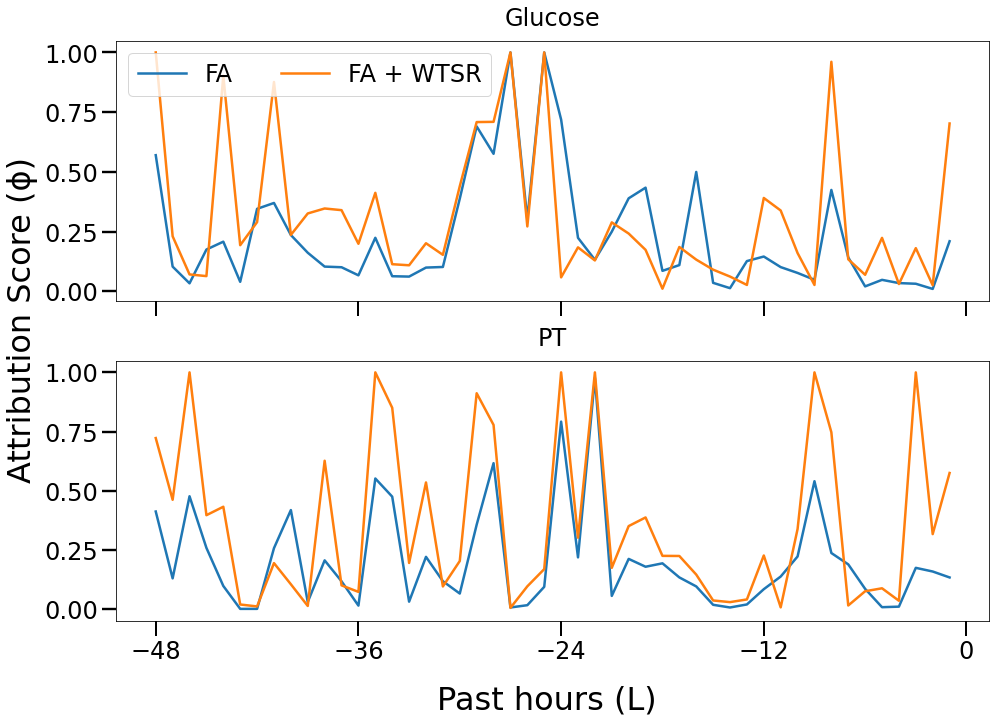

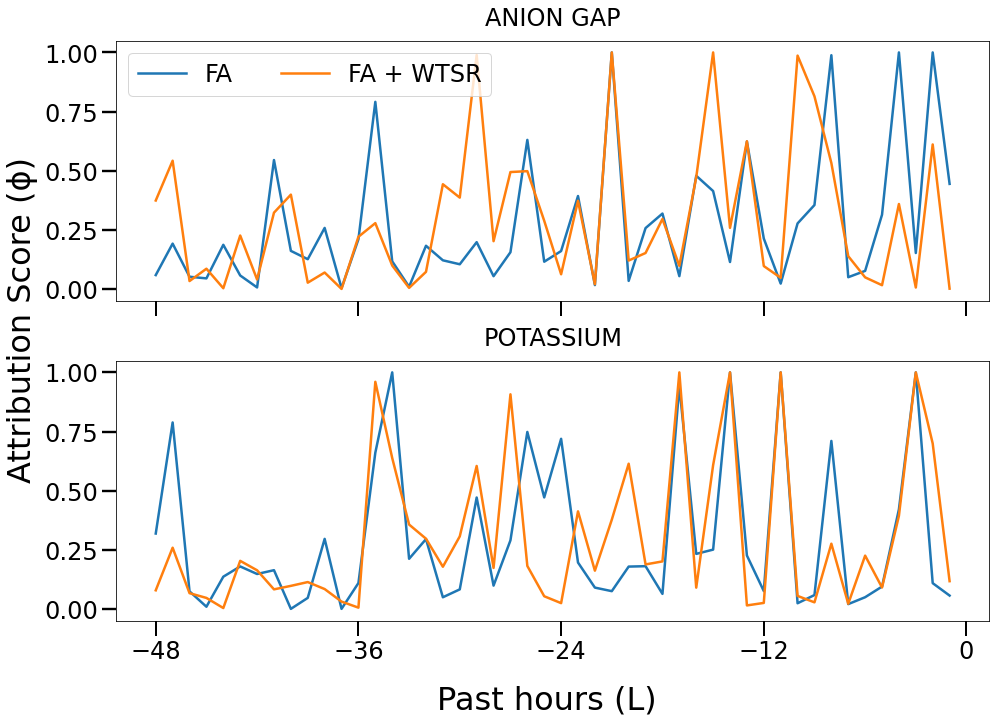

In [32]:
for patient in [dead_patient, alive_patient]:
    # taking absolute since we only care for magnitude
    attr_tsr = attrs_tsr[patient].abs().detach().cpu().numpy()
    attr = attrs[patient].abs().detach().cpu().numpy()
    
    attr_tsr = normalize(attr_tsr, axis=(1))
    attr = normalize(attr, axis=(1))

    most_impactful_feature = attr_tsr.sum(axis=0).argmax()

    # how many of the top features
    top_k = 2
    # index of those top features
    top_features = np.argpartition(attr_tsr.sum(axis=0), -top_k, axis=-1)[-top_k:]
    
    fig, axes = plt.subplots(top_k, figsize=(14, 10), sharex=True)
    
    for i in range(top_k):
        X = range(-attr.shape[0], 0)
        
        axes[i].plot(X, attr[:, top_features[i]], label='FA')
        axes[i].plot(X, attr_tsr[:, top_features[i]], label='FA + WTSR')
        axes[i].title.set_text(mimic_iii_features[top_features[i]])
        
        
        axes[i].xaxis.set_major_locator(MultipleLocator(base=12))

    axes[0].legend(loc='upper left', ncol=2)
    fig.supylabel('Attribution Score (ϕ)', fontsize=32, x=0.015, y=0.55)
    fig.supxlabel('Past hours (L)', fontsize=32, y=0, x=0.55)

    fig.tight_layout()
    
    # dead ptient
    if labels[patient] == 1:
        plt.savefig(os.path.join(output_folder, 'dead_salient_maps_before_and_after_wtsr.jpg'), dpi=200)
    else:
        plt.savefig(os.path.join(output_folder, 'alive_salient_maps_before_and_after_wtsr.jpg'), dpi=200)
    plt.show()
    # break

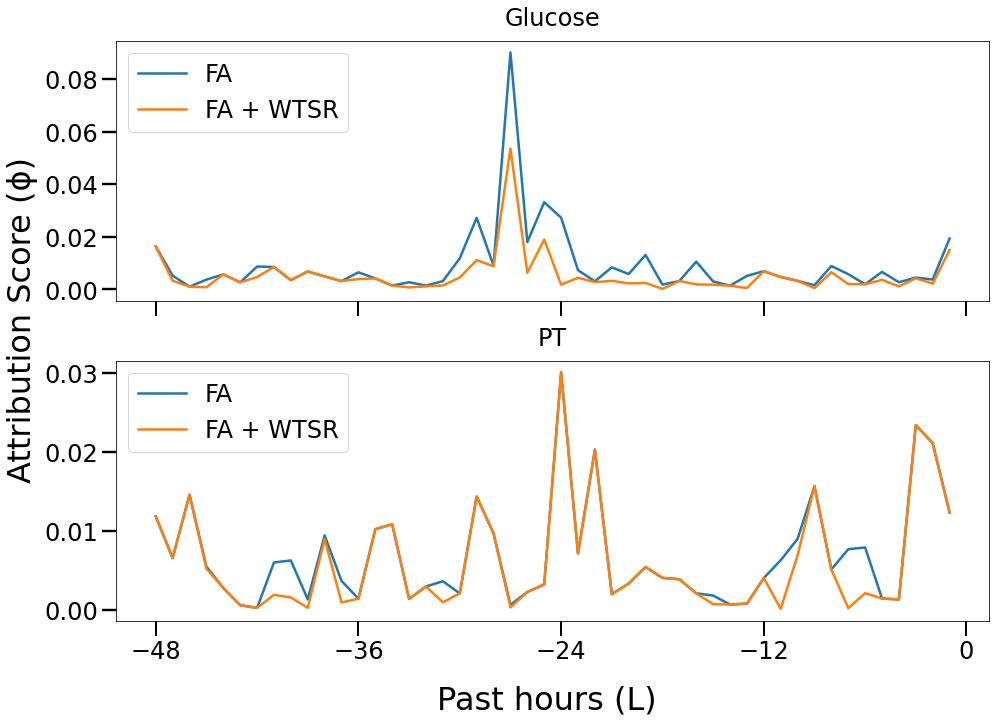

## Global difference

In [48]:
dead_patients = [i for i in range(labels.shape[0]) if labels[i] == 1]
alive_patients = [i for i in range(labels.shape[0]) if labels[i] == 0]

# taking absolute since we only care for magnitude
mean_attr_dead = attrs[dead_patients].abs().mean(dim=(0)).detach().cpu().numpy()
mean_attr_alive = attrs[alive_patients].abs().mean(dim=(0)).detach().cpu().numpy()

# how many of the top features
top_k = 2

### Dead patients

In [73]:
most_impactful_feature = mean_attr_dead.mean(axis=0).argmax()

# index of those top features
top_features = np.argpartition(mean_attr_dead.mean(axis=0), -top_k, axis=-1)[-top_k:]

# attr_normed = normalize(attr, axis=(1))

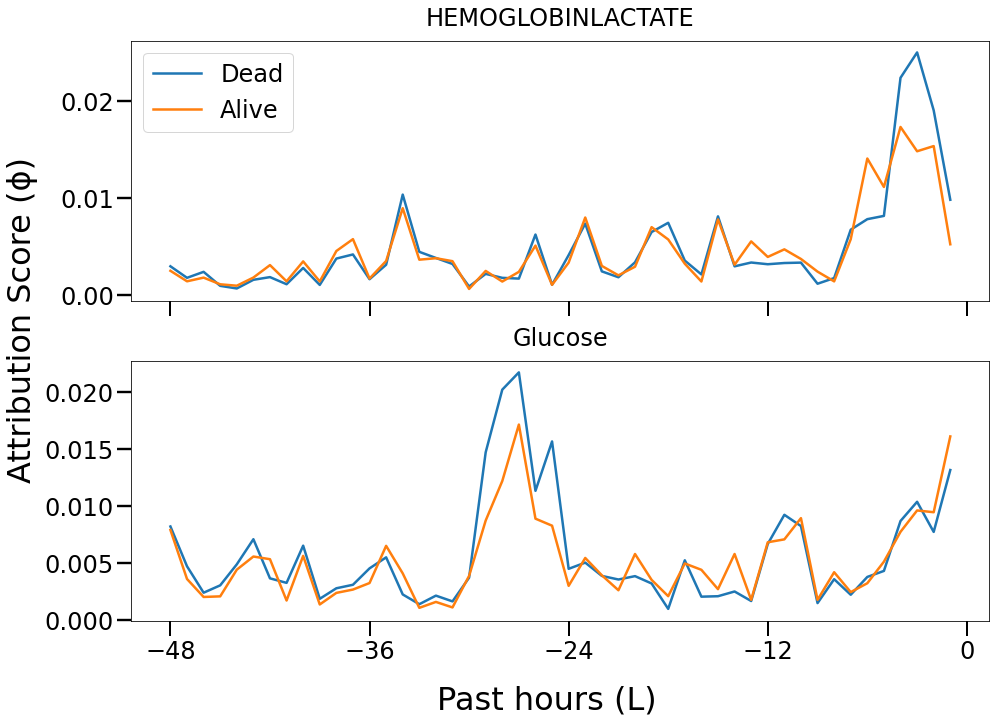

In [74]:
fig, axes = plt.subplots(top_k, figsize=(14, 10), sharex=True)
for i in range(top_k):
    X = range(-mean_attr_dead.shape[0], 0)
    axes[i].plot(X, mean_attr_dead[:, top_features[i]], label='Dead')
    axes[i].plot(X, mean_attr_alive[:, top_features[i]], label='Alive')
    
    axes[i].title.set_text(mimic_iii_features[top_features[i]])
    axes[i].xaxis.set_major_locator(MultipleLocator(base=12))

axes[0].legend(loc='upper left')
fig.supylabel('Attribution Score (ϕ)', fontsize=32, x=0.015, y=0.55)
fig.supxlabel('Past hours (L)', fontsize=32, y=0, x=0.55)

fig.tight_layout()
plt.savefig(os.path.join(output_folder, 'global_important_features_dead.jpg'), dpi=200)
plt.show()

### Alive patients

In [69]:
most_impactful_feature = mean_attr_alive.mean(axis=0).argmax()

# index of those top features
top_features = np.argpartition(mean_attr_alive.mean(axis=0), -top_k, axis=-1)[-top_k:]

# attr_normed = normalize(attr, axis=(1))

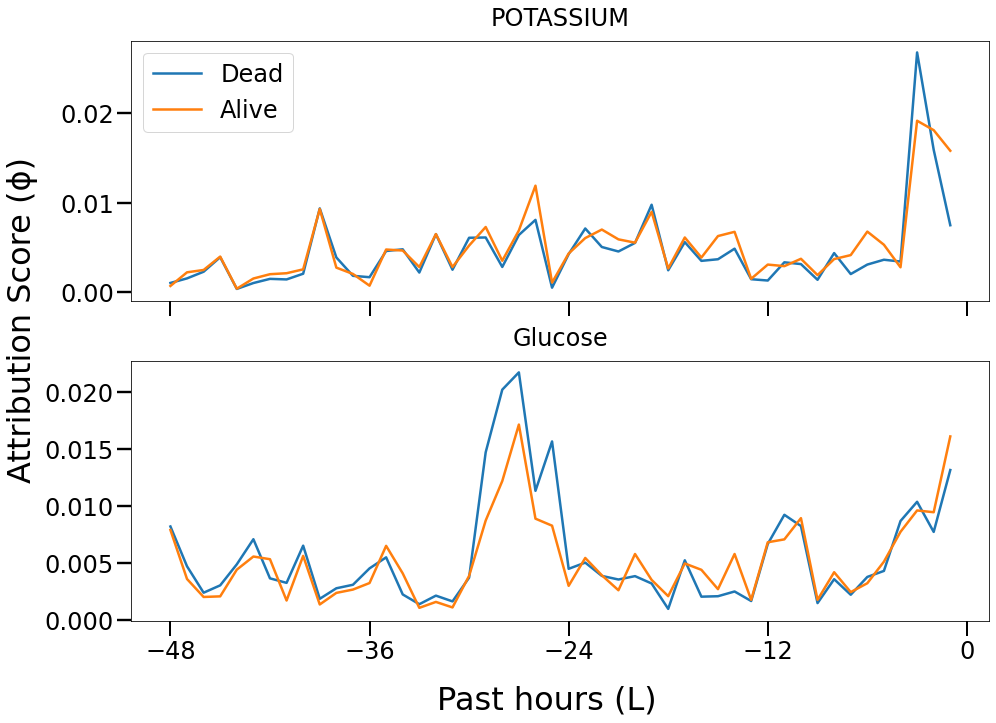

In [72]:
fig, axes = plt.subplots(top_k, figsize=(14, 10), sharex=True)

for i in range(top_k):
    X = range(-mean_attr_dead.shape[0], 0)
    axes[i].plot(X, mean_attr_dead[:, top_features[i]], label='Dead')
    axes[i].plot(X, mean_attr_alive[:, top_features[i]], label='Alive')
    
    axes[i].title.set_text(mimic_iii_features[top_features[i]])
    
    axes[i].xaxis.set_major_locator(MultipleLocator(base=12))

axes[0].legend(loc='upper left')
fig.supylabel('Attribution Score (ϕ)', fontsize=32, x=0.015, y=0.55)
fig.supxlabel('Past hours (L)', fontsize=32, y=0, x=0.55)

fig.tight_layout()
plt.savefig(os.path.join(output_folder, 'global_important_features_alive.jpg'), dpi=200)
plt.show()